In [63]:
import sys
sys.path.append('..')

from torch.utils.data import Dataset
import torch
import numpy as np
import os
from PIL import Image
import cv2
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

from utils import *
from scripts import *

import h5py
import scipy.io
import torchvision

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
mat = scipy.io.loadmat('/mnt/cfs/sihaozhe/DFV/data_preprocess/third_part/IntParamLF.mat')
mat = np.squeeze(mat['IntParamLF']) 

def disp2dpt(mat, disp):
    K2 = mat[1]
    fxy = mat[2:4]
    flens = max(fxy)
    fsubaperture = 521.4052 # pixel
    baseline = K2/flens*1e-3 # meters/ meter/px
    dpt = np.zeros_like(disp)
    dpt[disp!=0] = baseline*fsubaperture / disp[disp!=0]
    return dpt

In [69]:
K2 = mat[1]
fxy = mat[2:4]
flens = max(fxy)
fsubaperture = 521.4052 # pixel
baseline = K2/flens*1e-3 # meters/ meter/px
flens

7317.020641763665

In [53]:
disp_dist = torch.linspace(0.02,0.28, steps=10)
disp2dpt(mat, disp_dist)

array([7.0618787 , 2.8889503 , 1.8159118 , 1.3241023 , 1.0419166 ,
       0.8588771 , 0.73053914, 0.6355691 , 0.56245047, 0.5044199 ],
      dtype=float32)

In [54]:
f = h5py.File('/mnt/cfs/sihaozhe/DDFF12/ddff.h5', 'r')

In [61]:
f.keys()

<KeysViewHDF5 ['AiF_train', 'AiF_val', 'disp_train', 'disp_val', 'stack_train', 'stack_val']>

In [55]:
idx = 270
dpt = disp2dpt(mat, f['disp_train'][idx])

In [56]:
dpt

array([[1.0510001, 1.055    , 1.059    , ..., 0.       , 0.       ,
        0.       ],
       [1.0510001, 1.055    , 1.059    , ..., 0.       , 0.       ,
        0.       ],
       [1.0510001, 1.055    , 1.059    , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

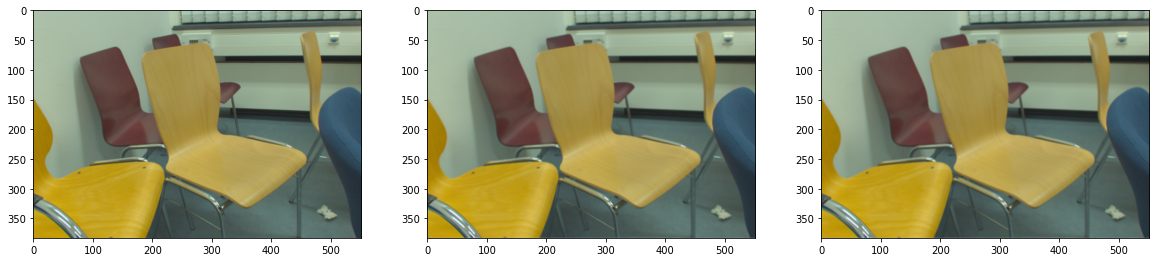

In [57]:
plt.figure(figsize=(20, 12))
plt.subplot(1, 3, 1)
plt.imshow(f['stack_train'][idx][9]/255.)
plt.subplot(1, 3, 2)
plt.imshow(f['stack_train'][idx][1]/255.)
plt.subplot(1, 3, 3)
plt.imshow(f['stack_train'][idx][0]/255.)

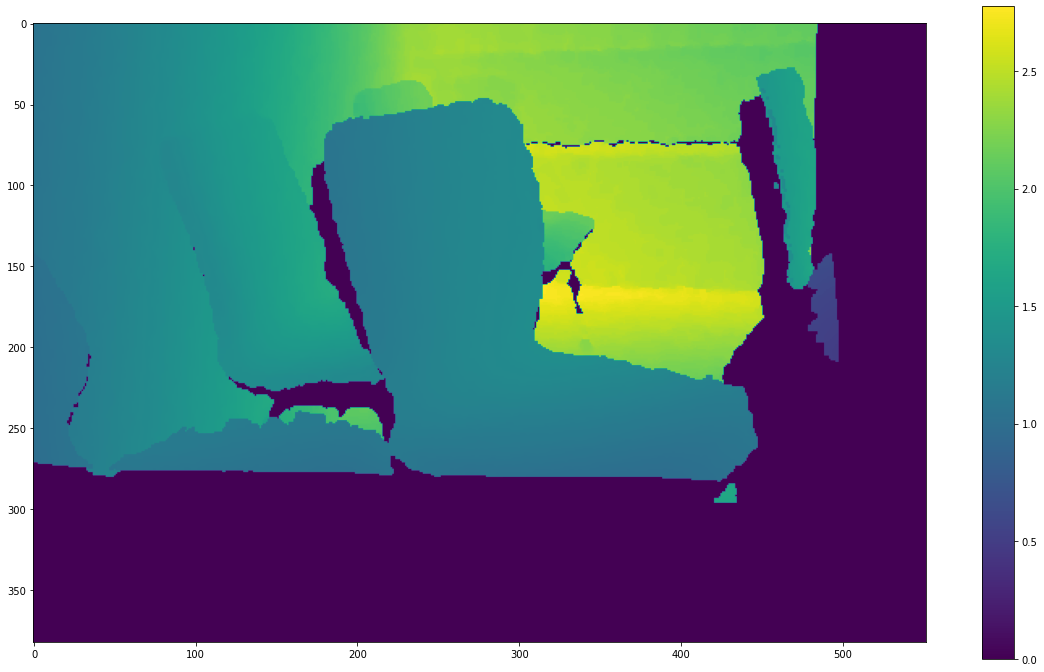

In [58]:
plt.figure(figsize=(20, 12))
plt.imshow(dpt)
plt.colorbar()

In [77]:
f['disp_train'][0].shape

(383, 552)

In [127]:
383//32*32

352

In [89]:
class DDFF12(Dataset):
    def __init__(self, root_dir, split='train', shuffle=False, img_num=10, visible_img=10, recon_all=True, RGBFD=True, DPT=True, AIF=True):
        self.hdf5 = h5py.File(root_dir, 'r')
        self.shuffle = shuffle
        self.img_num = img_num
        self.visible_img = visible_img
        self.disp_dist = torch.linspace(0.02,0.28, steps=10)
        self.focus_dist = torch.from_numpy(self.disp2dpt(self.disp_dist))
        self.recon_all = recon_all
        self.RGBFD = RGBFD
        self.DPT = DPT
        self.AIF = AIF
        
        ##### Load and sort all images
        self.imglist_all = self.hdf5[f'stack_{split}']
        self.imglist_disp = self.hdf5[f'disp_{split}']
        self.imglist_aif = self.hdf5[f'AiF_{split}']

        self.n_stack = self.imglist_all.shape[0]
        print(f"Total number of samples: {self.n_stack}\n{self.visible_img} out of {self.img_num} images per sample are visible for input")

    def __getitem__(self, idx):
        ##### Read and process an image
        img_idx = idx

        sub_idx = np.arange(self.img_num)
        if self.shuffle:
            np.random.shuffle(sub_idx)
        input_idx = sub_idx[:self.visible_img]
        if self.recon_all:
            output_idx = sub_idx
        else:
            output_idx = sub_idx[self.visible_img:]

        mats_input = []
        mats_output = []

        for i in sub_idx:
            mat_all = (self.imglist_all[idx][i]/255.).astype(np.float32)[:-15, :-8]
            if i in output_idx:    
                mats_output.append(torch.from_numpy(mat_all.transpose((2, 0, 1))).unsqueeze(0))
            if self.RGBFD and i in input_idx:   
                mat_fd = self.focus_dist[i].view(-1, 1, 1).expand(*mat_all.shape[:-1], 1).numpy()
                mat_all = np.concatenate([mat_all, mat_fd], axis=-1)                 
                mats_input.append(torch.from_numpy(mat_all.transpose((2, 0, 1))).unsqueeze(0))
        data = dict(output=torch.cat(mats_output), output_fd=self.focus_dist[output_idx])

        if self.RGBFD:
            data.update(rgb_fd = torch.cat(mats_input))

        if self.DPT:
            mat_dpt = self.disp2dpt(self.imglist_disp[idx])[:-15, :-8]
            mat_dpt = torch.from_numpy(mat_dpt)
            data.update(dpt = mat_dpt)

        if self.AIF:
            mat_aif = (self.imglist_aif[idx]/255.).astype(np.float32)[:-15, :-8]
            data.update(aif = torch.from_numpy(mat_aif.transpose(2, 0, 1)))

        return data
    
    def __len__(self):
        return self.n_stack
    
    def disp2dpt(self, disp):
        K2 = 1982.0250823695178
        flens = 7317.020641763665
        fsubaperture = 521.4052
        baseline = K2/flens*1e-3 # meters/ meter/px
        dpt = np.zeros_like(disp)
        dpt[disp!=0] = baseline*fsubaperture / disp[disp!=0]
        return dpt

In [129]:
ds = DDFF12('/mnt/cfs/sihaozhe/DDFF12/ddff.h5')

Total number of samples: 400
10 out of 10 images per sample are visible for input


In [130]:
ds[0]['rgb_fd'].shape

torch.Size([10, 4, 368, 544])

In [135]:
dataset_config = {
        'root_dir': '/mnt/cfs/sihaozhe/DDFF12/ddff.h5',
        'shuffle': True,
        'img_num':  10, 
        'visible_img': 10,
        'recon_all': True,
        'RGBFD': True,
        'DPT': True,
        'AIF': True,
        'near': 0.1,
        'far': 10,
    }

In [136]:
train_dl, _, _ = load_data(dataset_config, 'DDFF', 1)

Total number of samples: 400
10 out of 10 images per sample are visible for input
Total number of training sample: 400
Total number of testing sample: 200


In [137]:
sample = next(iter(train_dl))

In [139]:
sample['output'].shape

torch.Size([1, 10, 3, 176, 272])